This notebook, compares synchronous parallel SGD vs One-Shot Averaging (OSA) on quadratic functions and generates the speed-up curves.

# Quadratic Functions
$f(x) = x^2$ for $x>0$ and $\frac{1}{2}x^2$ for $x\leq 0$.

In [1]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import pickle

import numpy as np

In [2]:
import multiprocessing
from multiprocessing import Pool, TimeoutError

In [3]:
class arguments():
    x0 = 2

    T = 1000
    N = 20 #50

    mu = 1
    L = 2
    
    eta = 2/mu 
    
    sigma = 8.0
    
    reps = 50
    
    reps_su = 50
    reps_su_scale = {2:2, 4: 2, 8:2, 16:3, 24:3, 32:3}
    N_su = [2,4,8,16,24,32]

    T_sul = 8000
    reps_sul = 10
    reps_sul_scale = {32:1, 64:2, 128:2, 256:2}
    N_sul = sorted(reps_sul_scale.keys())
    
    
arg = arguments()

In [4]:
def f(x, arg):
    if x>=0:
        return (arg.mu)*(x**2)
    else:
        return 0.5*(arg.mu)*(x**2)

## calculate parameters for FedAC

In [5]:
def get_params_ac_1(arg, R=None, eta=None, N=None, T=None):
    if not T:
        T = arg.T
        
    if not N:
        N = arg.N
        
    if not R:
        R = np.ceil(arg.N**(1/2))
        
    phi0 = f(arg.x0, arg) + (arg.mu/2)*(arg.x0**2)
        
    H = arg.T/R
    
    if not eta:
        c = np.log(np.e + min(arg.mu*N*T*phi0/(arg.sigma**2),
                               (arg.mu**2)*(T**3)*phi0/((arg.L)*(H**2)*(arg.sigma**2))))**2
#         print(f'c: {c}')
        eta = min(1/arg.L, 1/(arg.mu*arg.T*R)*c)
    
    gamma = max(np.sqrt(eta/(arg.mu*H)), eta)
    alpha = 1/(gamma*arg.mu)
    beta = alpha + 1
    
    return eta, gamma, alpha, beta

get_params_ac_1(arg)

(0.009993239538096534,
 0.009993239538096534,
 100.06765035379863,
 101.06765035379863)

In [6]:
def get_params_ac_2(arg, R=None, eta=None, N=None, T=None):
    if not T:
        T = arg.T
        
    if not N:
        N = arg.N
        
    if not R:
        R = np.ceil(arg.N**(1/3))
        
    phi0 = f(arg.x0, arg) + (arg.mu/6)*(arg.x0**2)
        
    H = arg.T/R
    
    if not eta:
        c = np.log(np.e + min(arg.mu*N*T*phi0/(arg.sigma**2),
                               (arg.mu**3)*(T**4)*phi0/((arg.L**2)*(H**3)*(arg.sigma**2))))**2
#         print(f'c: {c}')
        eta = min(1/arg.L, 9/(arg.mu*arg.T*R)*c)
    
    gamma = max(np.sqrt(eta/(arg.mu*H)), eta)
    alpha = 1.5/(gamma*arg.mu) - 0.5
    beta = (2*(alpha**2)-1)/(alpha - 1)
    
    return eta, gamma, alpha, beta

get_params_ac_2(arg)

(0.11548252467793195,
 0.11548252467793195,
 12.48897823877106,
 27.06499641958199)

In [7]:
def g(x, arg, stochastic=True):
    if stochastic:
        noise = np.random.normal(0, arg.sigma)
    else:
        noise = 0
    if x>=0:
        return 2*(arg.mu)*x + noise
    else:
        return (arg.mu)*x + noise

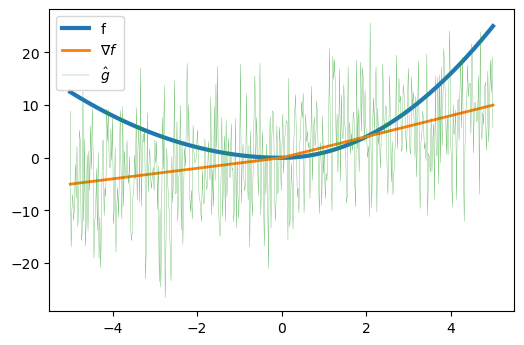

In [8]:
# plot function value and derivatives
X = np.linspace(-5,5,500)
fX = np.array([f(x,arg) for x in X])
gX = np.array([g(x,arg,False) for x in X])
hgX = np.array([g(x,arg,True) for x in X])

plt.figure(dpi=100)
plt.plot(X,fX, lw = 3, label = 'f')
plt.plot(X,gX, lw = 2, label = r'$\nabla f$')
plt.plot(X,hgX, lw = .2, label = r'$\hat g$')
plt.legend()
# plt.savefig('figures/function_plot.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

In [9]:
plot_labels = {
    'osa': r'$R=1$ (OSA)',
    'sync': 'Synchronous SGD',
    'constant': r'$R=N$, constant $H$',
    'increasing':  r'$R=N$, increasing $H$',
    'ac_1': r'$R=N^{1/2}$, FedAC-I',
    'ac_2': r'$R=N^{1/3}$, FedAC-II',
}

In [10]:
def get_comms(arg, mode='increasing', N=None, T=None):
    if not N:
        N = arg.N
    if not T:
        T = arg.T
        
    if mode == 'increasing':
        R = N
        a = 2*T/(R*(R+1))
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]
            
    elif mode == 'decreasing':
        comms = sorted([T - c for c in get_comms(arg, 'increasing', N, T)])
                
    elif mode == 'constant':
        R = N
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        
    elif mode == 'ac_1':
        R = int(np.ceil(N**(1/2)))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        
    elif mode == 'ac_2':
        R = int(np.ceil(N**(1/3)))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        
        
    elif mode == 'sync':
        comms = range(T+1)
        
    elif mode == 'osa':
        comms = [0,T]
        
    elif mode == 'N^1/2':
        R = int(np.ceil(np.sqrt(N)))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        
    elif mode == 'RN^1/2':
        R = int(np.ceil(np.sqrt(N)))
        a = 2*T/(R*(R+1))
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]
        
    elif mode == 'N^1/4':
        R = int(np.ceil(N**0.25))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
    
    elif mode == 'RN^1/4':
        R = int(np.ceil(N**0.25))
        a = 2*T/(R*(R+1))
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]
        
    elif mode == 'N^3/4':
        R = int(np.ceil(N**0.75))
        H = T/R
        comms = [int(H*r) for r in range(R+1)]
        
    elif mode == 'RN^3/4':
        R = int(np.ceil(N**0.75))
        a = 2*T/(R*(R+1))
        comms = [int(a*r*(r+1)/2) for r in range(R+1)]
    
    else:
        raise Exception("Mode not recognized!") 
        
    if comms[-1] != T:
        comms.append(T)
        
    if mode in {'increasing', 'constant', 'decreasing'}:
        assert len(comms) == (N+1), f"comm. rounds:{len(comms)-1}, N:{N}, comms: {comms}"
        
    return comms

In [11]:
# main loop
def get_errors(arg, comms, N=None, T=None):
    if not N:
        N = arg.N
    if not T:
        T = arg.T
        
    X = np.ones((N,1))*(arg.x0)

    iter_errors = [f(arg.x0, arg)]
    comm_errors = [f(arg.x0, arg)]

    singles = [] # error of SGD using single worker
    for t in range(T):
        # Gradient Step
        step_size = min((arg.eta)/(t+1), 1.0/arg.L)
        for n in range(N):
            X[n] -= step_size*g(X[n], arg)
            
        x_mean = X.mean()
        iter_errors.append(f(x_mean, arg))

        # Communication
        if (t + 1) in comms:
            if len(comms) == 2:
                singles = [f(X[i,0], arg) for i in range(N)]
            
            X = np.ones((N,1))*x_mean
            comm_errors.append(f(x_mean, arg))
    return {'iter':iter_errors, 'comm':comm_errors, 'singles':singles}

## FedAC
source: https://proceedings.neurips.cc/paper/2020/file/39d0a8908fbe6c18039ea8227f827023-Paper.pdf

In [12]:
def get_errors_AC(arg, comms, mode=1, eta=None, N=None, T=None):
    if not N:
        N = arg.N
    if not T:
        T = arg.T
        
    X = np.ones((N,1))*(arg.x0)
    
    # calculate FedAC parameters
    R = len(comms) - 1
    if mode == 1:
        eta, gamma, alpha, beta = get_params_ac_1(arg, R=R, eta=eta, N=N, T=T)
    elif mode == 2:
        eta, gamma, alpha, beta = get_params_ac_2(arg, R=R, eta=eta, N=N, T=T)
    else:
        raise ValueError
    
    W = np.ones((N,1))*(arg.x0)
    W_md = np.ones((N,1))*(arg.x0)
    W_ag = np.ones((N,1))*(arg.x0)
    
    V = np.zeros((N,1))
    V_ag = np.zeros((N,1))
    
    iter_errors = [f(arg.x0, arg)]
    comm_errors = [f(arg.x0, arg)]

    for t in range(T):
        W_md = W/beta + W_ag*(1 - 1/beta)
        # Gradient Step
        for n in range(N):
            g_n = g(W_md[n], arg)
            V_ag[n] = W_md[n] - eta*g_n
            V[n] = (1 - 1/alpha)*W[n] + (1/alpha)*W_md[n] - gamma*g_n
            
        v_mean = V.mean()
        iter_errors.append(f(v_mean, arg))

        # Communication
        if (t + 1) in comms:
            W = np.ones((N,1))*v_mean
            W_ag = np.ones((N,1))*(V_ag.mean())
            comm_errors.append(f(v_mean, arg))
        
        else:
            W = V
            W_ag = V_ag
            
    return {'iter':iter_errors, 'comm':comm_errors}

## Single Training

In [13]:
modes = {'osa', 'constant', 'sync', 'ac_1', 'ac_2'}
errors_dict = {}
singles = []
for mode in modes:
    comms = get_comms(arg, mode)
    if mode == 'ac_1':
        errors_dict[mode] = get_errors_AC(arg, comms, mode=1, eta=None)
    elif mode == 'ac_2':
        errors_dict[mode] = get_errors_AC(arg, comms, mode=2, eta=None)
    else:
        errors_dict[mode] = get_errors(arg, comms)

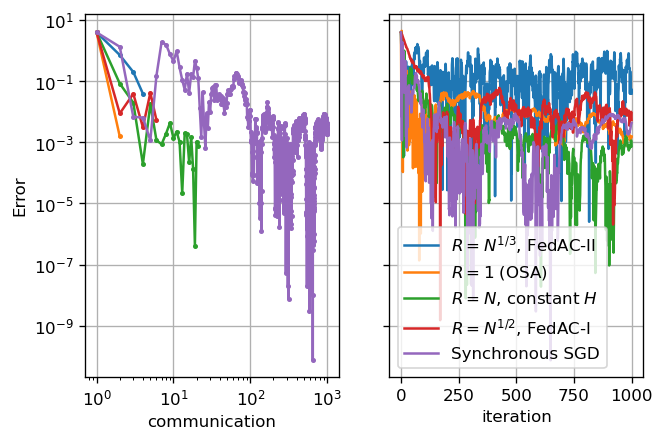

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row')

fig.set_figsize = (4,6)
fig.dpi = 120

for mode in modes:
    ax1.plot(np.arange(1, len(errors_dict[mode]['comm'])+1), errors_dict[mode]['comm'], '-o', ms= 2, label=plot_labels[mode])

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('communication')
ax1.set_ylabel('Error')
ax1.grid()

for mode in modes:
    ax2.plot(errors_dict[mode]['iter'], label=plot_labels[mode])
ax2.set_xlabel('iteration')

ax2.legend()
ax2.grid()
plt.show()

## Repeated Training

In [15]:
modes = {'osa', 'ac_1', 'ac_2', 'increasing'}
errors_dict = {}
for mode in modes:
    comms = get_comms(arg, mode)
    
    all_comm_errors = []
    all_iter_errors = []
    if mode == 'osa':
        all_singles = []
    
    for rep in range(arg.reps):
        if mode == 'ac_1':
            errors = get_errors_AC(arg, comms, mode=1)
        elif mode == 'ac_2':
            errors = get_errors_AC(arg, comms, mode=2)
        else:
            errors = get_errors(arg, comms)
        
        all_comm_errors.extend(errors['comm'])
        all_iter_errors.extend(errors['iter'])
        
        if mode == 'osa':
            all_singles.extend(errors['singles'])
        
    all_comm_errors = np.array(all_comm_errors).reshape(arg.reps,-1)
    all_iter_errors = np.array(all_iter_errors).reshape(arg.reps,-1)
    
    errors_dict[mode] = {'iter': all_iter_errors, 'comm': all_comm_errors}
    
    if mode == 'osa':
        all_singles = np.array(all_singles).reshape(arg.reps,-1)
        errors_dict['singles'] = all_singles

Mode: increasing, Speed-Up: 14.050746517140727
Mode: ac_1, Speed-Up: 3.065102687401741
Mode: ac_2, Speed-Up: 0.1842255754567113
Mode: osa, Speed-Up: 8.95598476194193


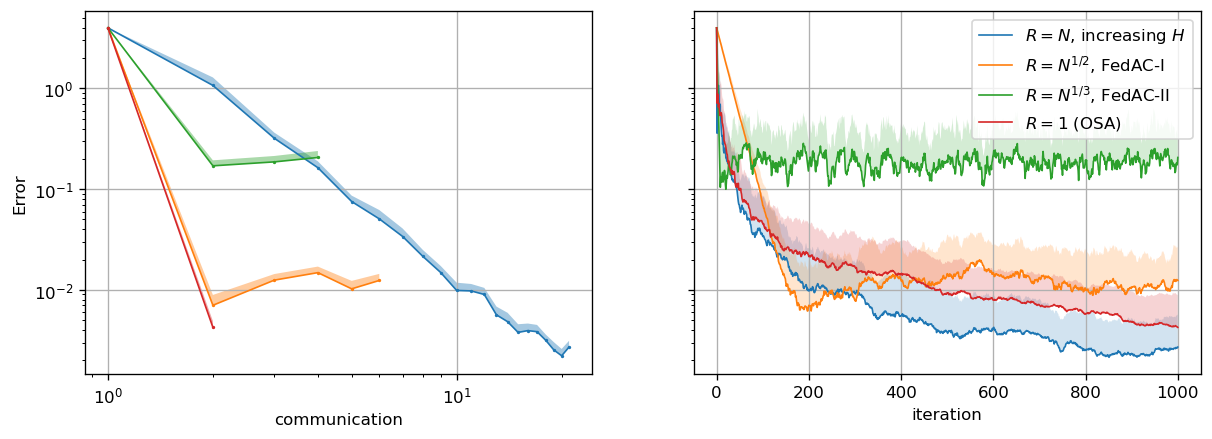

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4), dpi=120, sharey='row')

for mode in modes:
    error_mean = errors_dict[mode]['comm'].mean(axis=0)
    error_std = errors_dict[mode]['comm'].std(axis=0)/np.sqrt(arg.reps)
    x_values = np.arange(1, len(error_mean)+1)
    ax1.plot(x_values, error_mean, '-o', ms=1, lw=1, label=plot_labels[mode])
    ax1.fill_between(x_values,error_mean, error_mean + error_std, alpha = 0.4)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('communication')
ax1.set_ylabel('Error')
ax1.grid()

s1 = errors_dict['singles'].mean()

for mode in modes:
    error_mean = errors_dict[mode]['iter'].mean(axis=0)
    print(f"Mode: {mode}, Speed-Up: {s1/error_mean[-1]}")
    error_std = errors_dict[mode]['iter'].std(axis=0)
    ax2.plot(error_mean, lw=1, label=plot_labels[mode])
    ax2.fill_between(np.arange(len(error_mean)),error_mean, error_mean + error_std, alpha = 0.2)
ax2.set_xlabel('iteration')
ax2.legend()
ax2.grid()

plt.savefig('figures/1d_quadratic_errors.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

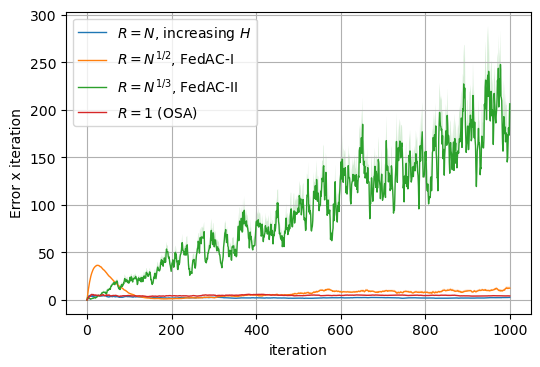

In [17]:
plt.figure(figsize=(6,4), dpi=100)
for mode in modes:
    error_mean = errors_dict[mode]['iter'].mean(axis=0)
    error_std = errors_dict[mode]['iter'].std(axis=0)/np.sqrt(arg.reps)
    plt.plot(error_mean*np.arange(len(error_mean)), lw=1, label=plot_labels[mode])
    plt.fill_between(np.arange(len(error_mean)), error_mean*np.arange(len(error_mean)), error_mean*np.arange(len(error_mean)) + error_std*(np.arange(len(error_mean))), alpha = 0.2)
plt.xlabel('iteration')
plt.ylabel('Error x iteration')
plt.grid()
plt.legend()

plt.show()

# Speed-Up

In [19]:
modes = [ 'ac_1', 'ac_2', 'osa', 'increasing'] #, 'sync']
errors_dict = {}
all_singles = []

for mode in modes:
    print(mode)
    errors_dict[mode] = {}
    for N in arg.reps_su_scale:
        reps = arg.reps_su * arg.reps_su_scale[N]
        print(N, end="..."),
        comms = get_comms(arg, mode, N)  # needs update

        all_iter_errors = []
        
        for rep in range(reps):
            if mode == 'ac_1':
                errors = get_errors_AC(arg, comms, mode=1, N=N)
            elif mode == 'ac_2':
                errors = get_errors_AC(arg, comms, mode=2, N=N)
            else:
                errors = get_errors(arg, comms, N)
            
            all_iter_errors.extend(errors['iter'])

            if mode == 'osa':
                all_singles.extend(errors['singles'])

        all_iter_errors = np.array(all_iter_errors).reshape(reps,-1)
        errors_dict[mode][N] = all_iter_errors
    print("")  

ac_1
2...4...8...16...24...32...
ac_2
2...4...8...16...24...32...
osa
2...4...8...16...24...32...
increasing
2...4...8...16...24...32...


In [20]:
### Save results to a file
file_name = 'results/OSA_SU.pkl'
with open( file_name, 'wb') as file:
    pickle.dump({'errors_dict': errors_dict, 'all_singles': all_singles, 'arg': arg}, file)
    file.close()
print('file saved: ' + file_name)

file saved: results/OSA_SU.pkl


In [21]:
# loading data
file_name = 'results/OSA_SU.pkl'
data = pickle.load(open(file_name, 'rb'))
print(data.keys())
try:
    errors_dict = data['errors_dict']
    all_singles = data['all_singles']
#     arg = data['arg']
except:
    pass

del data

dict_keys(['errors_dict', 'all_singles', 'arg'])


s1_mean: 0.041


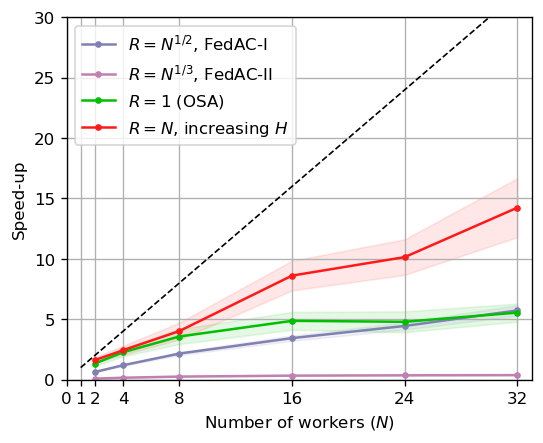

In [22]:
plot_colors = {
    'sync':(0.1, 0.1, 1),
    'increasing':(1, 0.1, 0.1),
    'constant':(1,.5,0.1),
    'osa':(0,.75,0),
    'ac_1': (0.5,0.5,0.7),
    'ac_2': (0.75,0.5,0.7),
}

plt.figure(figsize=(5,4), dpi=120)
n_smooth = 10


s1_mean = np.mean(all_singles)
s1_n_samples = np.shape(all_singles)[0]
s1_std = np.std(all_singles) / np.sqrt(s1_n_samples)


print(f"s1_mean: {s1_mean:.3f}")

speed_up = {}
for mode in errors_dict.keys(): #['sync', 'increasing', 'constant', 'osa']:
    errors_mean = []
    errors_std = []
    errors_inverse_mean = []
    errors_inverse_std = []

    for N in arg.N_su:
        n_samples = errors_dict[mode][N].shape[0]
        
        errors_mean.append(np.median(errors_dict[mode][N][:,n_smooth:], axis=1).mean())
        errors_std.append(np.median(errors_dict[mode][N][:,n_smooth:], axis=1).std() / np.sqrt(n_samples)) 
        
        errors_inverse_mean.append(np.median(1.0/errors_dict[mode][N][:,n_smooth:], axis=1).mean())
        errors_inverse_std.append(np.median(1.0/errors_dict[mode][N][:,n_smooth:], axis=1).std() / np.sqrt(n_samples))
        
    plt.plot(arg.N_su, s1_mean/np.array(errors_mean), '-o', ms=3 ,label=plot_labels[mode], color = plot_colors[mode])
    
    su_std = np.sqrt((np.array(errors_inverse_mean)*s1_std)**2 + (np.array(errors_inverse_std)*s1_mean)**2)
    plt.fill_between(arg.N_su, s1_mean/np.array(errors_mean) - su_std, s1_mean/np.array(errors_mean) + su_std, alpha = 0.1, color = plot_colors[mode])
    

plt.plot(range(1,33),range(1,33), '--', lw=1, c='black')

plt.xlabel(r'Number of workers ($N$)')
plt.ylabel('Speed-up')

plt.xticks([0,1,2,4,8,16,24,32])
# plt.axis('equal')
plt.axis([0,33,0,30])
plt.grid()
plt.legend()
plt.savefig('figures/speed-up.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()

# Lower bound?

In [23]:
## Parallel Processing

errors_dict = {}
all_singles = []
reps_mode_scale = {'increasing':8, 'constant':8, 'RN^3/4':6, 'N^3/4':6, 'RN^1/2':1, 'osa':1,
                  'ac_1':1, 'ac_2':1}

modes = [
    'ac_1',
    'ac_2',
    'osa',
#     'constant',
#     'increasing',
#     'RN^3/4',
    'RN^1/2',
#     'N^3/4',
]

if __name__ == '__main__':
    for mode in modes:
        print(mode)
        if not mode in errors_dict:
            errors_dict[mode] = {}
            
        for N in arg.N_sul:

            reps = arg.reps_sul * arg.reps_sul_scale[N] * reps_mode_scale[mode]

            print(f"{N}:{reps}x ", end="")
            comms = get_comms(arg, mode, N, arg.T_sul)
            
            with Pool(processes=8) as pool:
                if mode == 'ac_1':
                    multiple_results = [pool.apply_async(get_errors_AC, (arg, comms, 1, None, N, arg.T_sul,)) for i in range(reps)]
                elif mode == 'ac_2':
                    multiple_results = [pool.apply_async(get_errors_AC, (arg, comms, 2, None, N, arg.T_sul,)) for i in range(reps)]
                else:
                    multiple_results = [pool.apply_async(get_errors, (arg, comms, N, arg.T_sul,)) for i in range(reps)]
                
                all_errors = [res.get() for res in multiple_results]
                all_iter_errors = [error['iter'] for error in all_errors]

                if mode == 'osa':
                    for error in all_errors:
                        all_singles.extend(error['singles'])

            all_iter_errors = np.array(all_iter_errors).reshape(reps,-1)
            errors_dict[mode][N] = all_iter_errors
        print("Done!")

ac_1
32:10x 64:20x 128:20x 256:20x Done!
ac_2
32:10x 64:20x 128:20x 256:20x Done!
osa
32:10x 64:20x 128:20x 256:20x Done!
RN^1/2
32:10x 64:20x 128:20x 256:20x Done!


In [24]:
# Save results to a file
file_name = 'results/OSA_SUL.pkl'
with open( file_name, 'wb') as file:
    pickle.dump({'errors_dict': errors_dict, 'all_singles': all_singles, 'arg': arg}, file)
    file.close()
print('file saved: ' + file_name)

file saved: results/OSA_SUL.pkl


In [25]:
# loading data
file_name = 'results/OSA_SUL.pkl'
data = pickle.load(open(file_name, 'rb'))
print(data.keys())
try:
    errors_dict = data['errors_dict']
    all_singles = data['all_singles']
    arg = data['arg']
except:
    pass

del data

dict_keys(['errors_dict', 'all_singles', 'arg'])


In [26]:
plot_labels = {
    'osa': r'$R=1$ (OSA)',
    'constant': r'$R=N$, constant $H$',
    'increasing':  r'$R=N$, increasing $H$',
    'RN^1/2': r'$R=N^{1/2}$, increasing $H$',
    'RN^3/4': r'$R=N^{3/4}$, increasing $H$',
    'N^3/4': r'$R=N^{3/4}$, constant $H$',
#     'RN^1/4': r'$R=N^{1/4}$, increasing $H$',
    'ac_1': r'FedAC-I, $R=N^{1/2}$',
    'ac_2': r'FedAC-II, $R=N^{1/3}$',
              }

plot_colors = {
    'sync':(0.1, 0.1, 1),
    'increasing':(1, 0.1, 0.1),
    'constant':(1,.5,0.1),
    'osa':(0,.75,0),
    'RN^1/2': 'purple',
    'RN^3/4': 'brown',
    'N^3/4': 'deepskyblue',
#     'RN^1/4': 'brown',
    'ac_1': 'red',
    'ac_2': 'blue',
}

s1_mean: 0.005


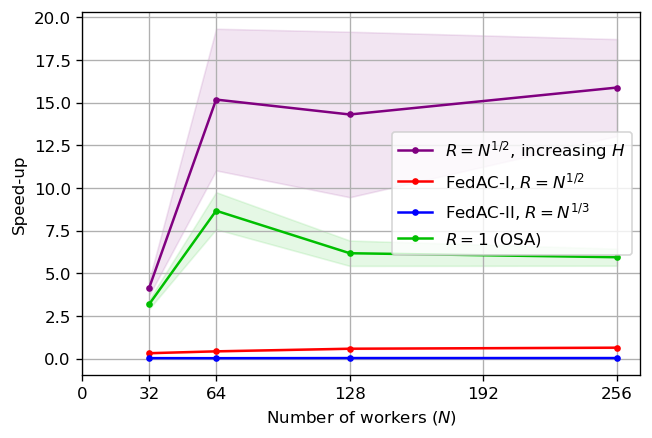

In [27]:
plt.figure(figsize=(6,4), dpi=120)

n_smooth = 10

s1_mean = np.mean(all_singles)
s1_n_samples = np.shape(all_singles)[0]
s1_std = np.std(all_singles) / np.sqrt(s1_n_samples)


print(f"s1_mean: {s1_mean:.3f}")

speed_up = {}
for mode in ['RN^1/2', 'ac_1', 'ac_2', 'osa']: #['increasing', 'constant', 'RN^3/4', 'N^3/4', 'RN^1/2', 'osa']:
    errors_mean = []
    errors_std = []
    errors_inverse_mean = []
    errors_inverse_std = []
    
    Ns = arg.N_sul # errors_dict[mode].keys()
    for N in Ns: #arg.N_sul:
        n_samples = errors_dict[mode][N].shape[0]
        
        errors_mean.append(np.median(errors_dict[mode][N][:,n_smooth:], axis=1).mean())
        
        errors_inverse_mean.append(np.median(1.0/errors_dict[mode][N][:,n_smooth:], axis=1).mean())
        errors_inverse_std.append(np.median(1.0/errors_dict[mode][N][:,n_smooth:], axis=1).std() / np.sqrt(n_samples))
    
    ls = 'o-'
    if mode == 'N^3/4':
        ls = '--'
    plt.plot(Ns, s1_mean/np.array(errors_mean), ls, ms=3 ,label=plot_labels[mode], color = plot_colors[mode])
    
    su_std = np.sqrt((np.array(errors_inverse_mean)*s1_std)**2 + (np.array(errors_inverse_std)*s1_mean)**2)
    plt.fill_between(Ns,
                     s1_mean/np.array(errors_mean) - su_std,
                     s1_mean/np.array(errors_mean) + su_std,
                     alpha = 0.1, color = plot_colors[mode])
    

plt.xlabel(r'Number of workers ($N$)')
plt.ylabel('Speed-up')

# plt.axis('equal')
plt.xticks([0,32, 64, 128, 192, 256])
# plt.axis([0,260,0,140])
plt.grid()
plt.legend()
plt.savefig('figures/speed-up-lower.png', dpi=240, transparent=False, bbox_inches='tight')
plt.show()